In [38]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [22]:
stock_data =pd.read_csv('TATACHEM.csv',index_col='Date')
stock_data.head()

In [23]:
df = pd.DataFrame(stock_data)
df.dropna(inplace=True)

In [24]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,204.350006,225.000000,203.500000,204.100006,69.403831,4700.0
1,1996-01-02,204.100006,204.000000,200.000000,200.699997,68.247650,10300.0
2,1996-01-03,200.699997,201.850006,200.000000,201.100006,68.383652,5900.0
3,1996-01-04,201.100006,200.000000,196.550003,199.000000,67.669563,7750.0
4,1996-01-05,199.000000,198.000000,195.000000,196.800003,66.921463,6800.0
...,...,...,...,...,...,...,...
6923,2023-07-04,1010.599976,1029.000000,1004.849976,1006.849976,1006.849976,2029338.0
6924,2023-07-05,1010.000000,1016.500000,1003.549988,1007.349976,1007.349976,612300.0
6925,2023-07-06,1009.400024,1018.000000,1004.650024,1012.799988,1012.799988,566109.0
6926,2023-07-07,1014.099976,1026.000000,995.500000,1002.200012,1002.200012,1235538.0


In [25]:
# Step 2: Create lag features for the LSTM model
def create_lag_features(data, lag=1):
    data['Close_Lag'] = data['Close'].shift(lag)
    return data.dropna()

In [26]:
# Create lag features for the LSTM model with a lag of 1 (you can experiment with different lags)
stock_data = create_lag_features(stock_data)

In [27]:
# Step 3: Split the data into train and test sets
train_data, test_data = train_test_split(stock_data, test_size=0.2, shuffle=False)

In [28]:
# Step 4: Train the LSTM model
X_train_lstm = np.array(train_data['Close_Lag']).reshape(-1, 1)
y_train_lstm = np.array(train_data['Close'])

In [29]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

In [30]:
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, 1))

early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=1, callbacks=[early_stopping], verbose=0)

In [31]:
# Step 5: Get LSTM predictions
X_test_lstm = np.array(test_data['Close_Lag']).reshape(-1, 1)
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, 1))
lstm_predictions = model_lstm.predict(X_test_lstm)

44/44 [==============================] - 3s 3ms/step


In [32]:
# Step 6: Train the XGBoost model
X_train_xgb = np.array(train_data['Close_Lag']).reshape(-1, 1)
y_train_xgb = np.array(train_data['Close'])

model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
# Step 7: Get XGBoost predictions
X_test_xgb = np.array(test_data['Close_Lag']).reshape(-1, 1)
xgb_predictions = model_xgb.predict(X_test_xgb)


In [34]:
# Step 8: Combine predictions for the final dataset
final_predictions = pd.DataFrame({'LSTM_Predictions': lstm_predictions.flatten(),
                                  'XGBoost_Predictions': xgb_predictions,
                                  'Close': test_data['Close']})

In [35]:
# Step 9: Train the final Random Forest model
X_train_final = np.array(final_predictions[['LSTM_Predictions', 'XGBoost_Predictions']])
y_train_final = np.array(final_predictions['Close'])
model_final = RandomForestRegressor()
model_final.fit(X_train_final, y_train_final)


RandomForestRegressor()

In [36]:
# Step 10: Make final predictions
X_test_final = np.array(final_predictions[['LSTM_Predictions', 'XGBoost_Predictions']])
final_predictions['Final_Predictions'] = model_final.predict(X_test_final)

In [37]:
# Evaluate the final model
mse_final = mean_squared_error(final_predictions['Close'], final_predictions['Final_Predictions'])
print(f"Mean Squared Error (MSE) of the final model: {mse_final}")

Mean Squared Error (MSE) of the final model: 71.75248960249705


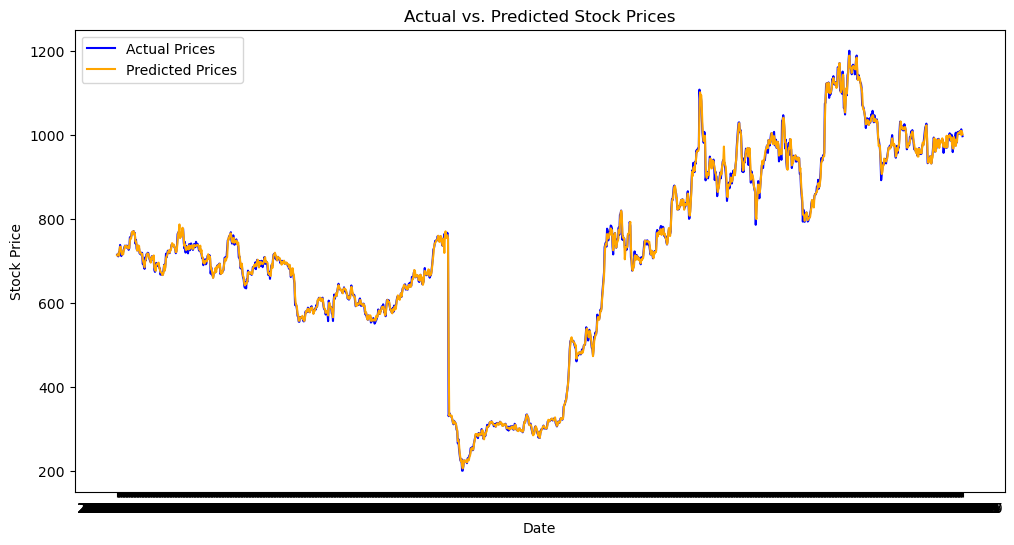

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], test_data['Close'], label='Actual Prices', color='blue')
plt.plot(test_data['Date'], final_predictions['Final_Predictions'], label='Predicted Prices', color='orange')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()